# Lab: Learning about Convolutional Neural Networks


In this notebook, you will learn how to use a Convolutional Neural Network (CNN) to classify digits from the MNIST dataset. This assignment will introduce the concept of convolutional layers, filters, and pooling layers, and how they differ from the simple feedforward neural network you used in the previous assignment.


## 1. Learning objectives

1. Implement a convolutional architecture
2. Understand convolutional filters and pooling layers
3. Compare performance with a feedforward network

## 2. Import the required libraries and data

We will use Keras again to build the convolutional model.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-11-11 18:50:40.949150: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 18:50:40.952718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 18:50:40.964631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731347440.982612   10014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731347440.987407   10014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 18:50:41.003121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Import the MNIST dataset.

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

We are going to normalize the dataset to pixel values between 0 and 1. In addition, convolutional networks take 3-D arrays as inputs. They use arrays of the form width x height x nb of channels. The number of channels refers to the color channels: RGB has three channels, greyscale (the case of MNIST) has 1 channel.

Since we are operating in greyscale, we are transforming the input into a 3-D array, but effectively it contains the same information as the 2-D array.

Each input in its original form looks like:
[[pixel_0, pixel_1, pixel_2, ..., pixel_27],
 [pixel_28, pixel_29, pixel_30, ..., pixel_55],
 ...
 [pixel_756, pixel_757, pixel_758, ..., pixel_783]]

 After turning it into a 3-D array:
 [[[pixel_0, pixel_1, pixel_2, ..., pixel_27],
  [pixel_28, pixel_29, pixel_30, ..., pixel_55],
  ...
  [pixel_756, pixel_757, pixel_758, ..., pixel_783]]]

If the pixels has RGB values, the 3-D array would look like:
[
    [[R_pixel_0, G_pixel_0, B_pixel_0], [R_pixel_1, G_pixel_1, B_pixel_1], ..., [R_pixel_27, G_pixel_27, B_pixel_27]],
    [[R_pixel_28, G_pixel_28, B_pixel_28], [R_pixel_29, G_pixel_29, B_pixel_29], ..., [R_pixel_55, G_pixel_55, B_pixel_55]],
    ...
    [[R_pixel_756, G_pixel_756, B_pixel_756], [R_pixel_757, G_pixel_757, B_pixel_757], ..., [R_pixel_783, G_pixel_783, B_pixel_783]]
]



In [3]:
# Normalize the images to values between 0 and 1 by dividing by 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the data to include the channel dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Check the shape of the data
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


## 3. Understanding Convolutional Neural Networks (CNNs)

A **Convolutional Neural Network (CNN)** is a type of neural network designed to work with image data. Unlike the feedforward neural network from the first assignment, which treats the input as a flat vector, CNNs take advantage of the 2D structure of images. Instead of flattening the image, CNNs process the image in its original form (28x28 pixels, in this case).

### What is a Convolutional Layer?

A **Convolutional Layer** is the building block of a CNN. It works by applying a set of filters (also called kernels) to the input image. Each filter slides over the image and performs an operation called **convolution**.

#### Filters and Feature Extraction:
- **Filters (Kernels)**: A filter is a small matrix (e.g., 3x3, 5x5) that scans across the image. Each filter is designed to detect specific patterns in the image, such as edges, textures, or shapes.

- **Convolution Operation**: When a filter passes over a portion of the image, it computes the dot product between the filter and the image pixels beneath it. This operation highlights certain features, such as vertical or horizontal edges.

Let's visualize this. The following code will randomly initialize a 3x3 filter and apply it to an MNIST digit.


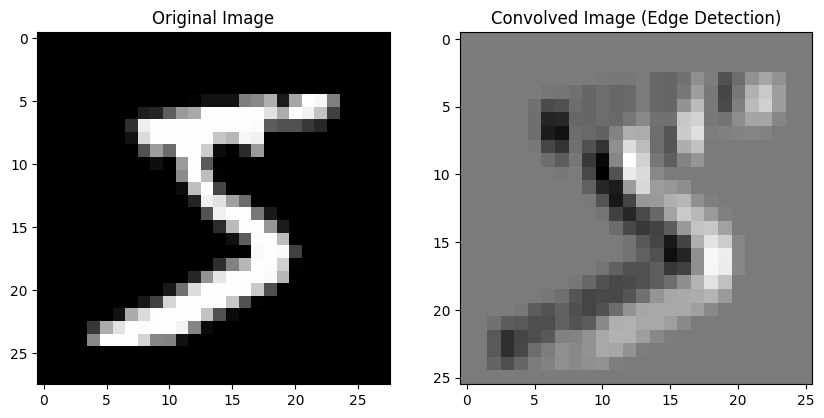

In [4]:
# Visualizing how a convolution works with a 3x3 filter

# Select a sample image from the dataset
sample_image = x_train[0].reshape(28, 28)

# Create a 3x3 filter
filter_example = np.array([[1, 0, -1],
                           [1, 0, -1],
                           [1, 0, -1]])

# Perform convolution operation manually
def convolve(image, filter):
    filter_size = filter.shape[0]
    output = np.zeros((image.shape[0] - filter_size + 1, image.shape[1] - filter_size + 1))
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = np.sum(image[i:i+filter_size, j:j+filter_size] * filter)
    return output

convolved_image = convolve(sample_image, filter_example)

# Plot the original and convolved images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image (Edge Detection)')
plt.show()


### Pooling Layers

After the convolutional layers extract features from the image, we often apply **Pooling Layers**. Pooling layers are used to reduce the spatial dimensions (height and width) of the convolved feature maps, which helps reduce the number of parameters and computations, and also makes the model more robust to small variations in the input.

#### Max Pooling:
- The most common type of pooling is **Max Pooling**, where we take the maximum value from a patch of the feature map.
- For example, in a 2x2 max-pooling operation, a 2x2 patch of the feature map is reduced to a single value (the maximum in that patch).

Let’s build a simple CNN with a convolutional layer and a max-pooling layer.


In [5]:
# Build a CNN model
model_cnn = keras.Sequential()

# Add a convolutional layer
# Filters = 32 (number of filters), kernel_size = (3,3) means 3x3 filters, activation function = ReLU
model_cnn.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

# Add a max-pooling layer
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer
model_cnn.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another max-pooling layer
model_cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and connect to a Dense layer for classification
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(128, activation='relu'))

# Add the output layer with 10 neurons (for 10 digits) and softmax activation
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_cnn.summary()


/home/nad/Documents/Master/SharedFolderVB/masters-degree/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-11 18:50:43.913865: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Why is the output of the first convolutional layer of dimension (26, 26,32)? Why is the output of the first conv2d layer of dimension (13, 13, 32)?

### Training the CNN

We will now train the CNN on the MNIST dataset, just like in the first assignment, but this time with convolutional layers extracting features from the images.


In [6]:
# Train the model
history = model_cnn.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(x_test, y_test)

print(f"Test accuracy: {test_acc}")


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9121 - loss: 0.2902 - val_accuracy: 0.9869 - val_loss: 0.0369
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9861 - loss: 0.0436 - val_accuracy: 0.9888 - val_loss: 0.0357
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.9920 - val_loss: 0.0247
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9943 - loss: 0.0174 - val_accuracy: 0.9884 - val_loss: 0.0357
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9958 - loss: 0.0125 - val_accuracy: 0.9914 - val_loss: 0.0270
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9883 - loss: 0.0345
Test accuracy: 0.9914000034332275


### Comparing CNNs to Feedforward Networks

- In the first assignment, you used a feedforward neural network (fully connected layers) to classify the digits, and you might have noticed that the model achieved high accuracy but did not take the 2D structure of the image into account.
- CNNs, on the other hand, are designed specifically for image data, and they use convolutional layers to automatically detect important features, such as edges, textures, and shapes.

#### Key Differences Between CNNs and Feedforward Networks:
- **Local Connectivity**: CNNs use small filters to connect only a local region of the input image (e.g., 3x3 or 5x5), while feedforward networks connect each neuron to every pixel in the image.
- **Parameter Sharing**: In CNNs, the same filter is applied across the entire image, which reduces the number of parameters compared to a fully connected layer.
- **Spatial Hierarchy**: CNNs learn hierarchical representations, where lower layers capture simple features (edges, corners), and higher layers capture more complex patterns (shapes, objects).

CNNs are typically much better suited for image classification tasks, as you will see in the higher accuracy when compared to your previous feedforward network.



# Visualising learnt filters

We can visualise the 3x3 filters learnt by the first convolutional layer by obtaining the weights of that layer and plotting them. We will set dark squares to indicate small or inhibitory weights and light squares
 to represent large or excitatory weights.



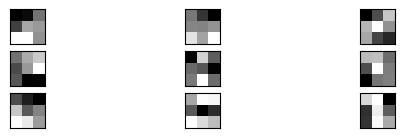

In [7]:
from matplotlib import pyplot

# retrieve weights from the first convolutional layer
filters, biases = model_cnn.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first n filters
n_filters, ix = 9, 1
for i in range(n_filters):
	# get the filter
  f = filters[:, :, :, i]
  # specify subplot and turn of axis
  ax = pyplot.subplot(n_filters, 3, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  pyplot.imshow(f[:, :, 0], cmap='gray')
  ix += 1
# show the figure
pyplot.show()

We can see, for example, that the third filter specifically looks for changes between the right upper corner and the pixels surrounding it.

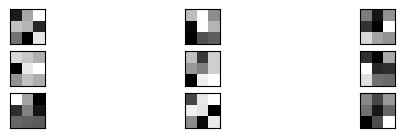

In [8]:
# retrieve weights from the seconf convolutional layer
filters, biases = model_cnn.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first n filters
n_filters, ix = 9, 1
for i in range(n_filters):
	# get the filter
  f = filters[:, :, :, i]
  # specify subplot and turn of axis
  ax = pyplot.subplot(n_filters, 3, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  pyplot.imshow(f[:, :, 0], cmap='gray')
  ix += 1
# show the figure
pyplot.show()